# LaplaceInterpolation.jl -- Usage and Examples.

This notebook demonstrates the usage of LaplaceInterploation.jl for interpolating missing data in 1D, 2D, and 3D problems. The package implements an approximate Laplace interpolation <cite data-cite="press1992">[1]</cite> when no parameters are given, and when parameters $m\in\mathbb{Z}$ and $\epsilon > 0$ are set, the interpolant approximates a Mat\`ern kernel, of which radial basis functions and polyharmonic splines are a special case. When all the data on the boundaries are known, the package automatically enforces a Dirichlet boundary condition. When the data on the boundaries are unknown, the package provides an option of implementing either Neumann boundary conditions -- that is, the derivative of the function at the unknown boundaries is 0 <cite data-cite="strikwerda2004">[2]</cite>, or by approximating the boundary node as the average of all the neighboring nodes. We refer to the latter as "Do Nothing" boundary conditions.

In [113]:
using LaplaceInterpolation
using Plots, Random, TestImages
using LinearAlgebra, FileIO, JLD

In [114]:
function f(x)
    return x .* sin.(x)
end

f (generic function with 2 methods)

# 1D Example

## Generating synthetic data 

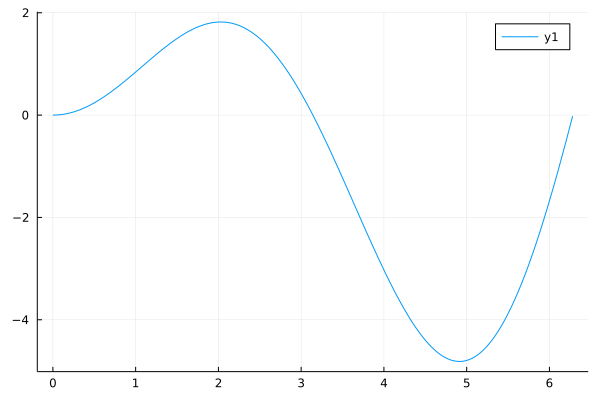

In [115]:
h = 0.01
x = 0:h:2*pi
y = f(x)
no_of_gridpoints = length(x) 
plot(x,y)

## Interpolation with Dirichlet Boundaries

We will discard about 90% of the points. We also want to ensure that we do not discard the boundaries -- that is to ensure the values at the boundaries are specified. 

In [162]:
rng = MersenneTwister(1234);
discard = randsubseq(rng, 2:no_of_gridpoints-1, 0.9) 
incomplete_data = copy(y)
incomplete_data[discard].= NaN; 

We assign `NaN` (or any arbitrary value) for the missing data.

In [163]:
m = 1
epsilon = 0
restored_data_laplace = matern_1d_grid(incomplete_data, discard, m, epsilon, h);

Note that the Dirichlet boundaries are implemented by default.

In [164]:
error_lap = abs.(restored_data_laplace .- y);
rel_error_lap = abs.((restored_data_laplace .- y) ./ (y .+ 1e-10));

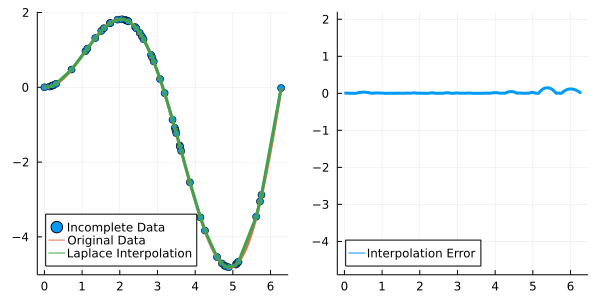

In [165]:
Plot_Matrix = [y, restored_data_laplace]

plot1 = plot(x, incomplete_data, seriestype = :scatter, label="Incomplete Data", size = (600, 300))
plot1 = plot(plot1, x, Plot_Matrix, labels=["Original Data" "Laplace Interpolation"],
            legend=:bottomleft, lw = 3, size = (600, 300))
plot2 = plot(x, error_lap, legend=:bottomleft, label = "Interpolation Error", 
            size = (600, 300), lw=3, ylim= [-4.7, 2])
plot(plot1, plot2, layout = (1, 2))

## Interpolation with Neumann Boundaries

When the boundary nodes are unknown, we enforce a zero Neumann boundary condition -- that is the derivative of the function along the outward normal at the boundaries is 0. In 1D, $\displaystyle \frac{\partial f}{\partial x} = 0$ at the end points.

In [166]:
rng = MersenneTwister(12345);
discard = randsubseq(rng, 2:no_of_gridpoints-1, 0.9) 
discard = [1; discard; no_of_gridpoints]; # we are including the boundaries in the set of discarded nodes.
incomplete_data = copy(y)
incomplete_data[discard].= NaN; 

In [167]:
m = 1
epsilon = 0
bc = 1 
restored_data_laplace = matern_1d_grid(incomplete_data, discard, m, epsilon, h, bc); 

`bc = 1` implements Neumann boundary conditions.

In [168]:
error_lap = abs.(restored_data_laplace .- y);
rel_error_lap = abs.((restored_data_laplace .- y) ./ (y .+ 1e-10));

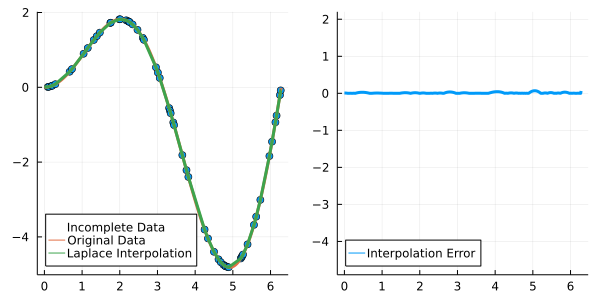

In [169]:
Plot_Matrix = [y, restored_data_laplace]

plot1 = plot(x, incomplete_data, seriestype = :scatter, label="Incomplete Data", size = (600, 300))
plot1 = plot(plot1, x, Plot_Matrix, labels=["Original Data" "Laplace Interpolation"],
            legend=:bottomleft, lw = 3, size = (600, 300))
plot2 = plot(x, error_lap, legend=:bottomleft, label = "Interpolation Error", 
            size = (600, 300), lw=3, ylim= [-4.7, 2])
plot(plot1, plot2, layout = (1, 2))

## Interpolation with "Do Nothing" Boundaries
When the boundary nodes are unknown, we approximate the unknown boundary values as the average of their neighbors.
For example in 1D, $f_0 = f_1$ and $f_N = f_{N-1}$. In 2D, $\displaystyle f_{0,0} = \frac{f_{1,0} + f_{0,1}}{2}$ and  $\displaystyle f_{1,0} = \frac{f_{0,0} + f_{2,0} +f_{1,1}}{3}$. 

In [170]:
rng = MersenneTwister(12345);
discard = randsubseq(rng, 2:no_of_gridpoints-1, 0.9) 
discard = [1; discard; no_of_gridpoints]; 
incomplete_data = copy(y)
incomplete_data[discard].= NaN; 

In [171]:
m = 1
epsilon = 0
bc = 0 
restored_data_laplace = matern_1d_grid(incomplete_data, discard, m, epsilon, h, bc); 

`bc = 0` implements "Do nothing" boundary conditions.

In [172]:
error_lap = abs.(restored_data_laplace .- y);
rel_error_lap = abs.((restored_data_laplace .- y) ./ (y .+ 1e-10));

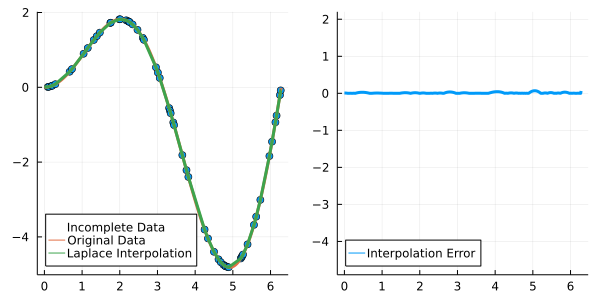

In [173]:
Plot_Matrix = [y, restored_data_laplace]

plot1 = plot(x, incomplete_data, seriestype = :scatter, label="Incomplete Data", size = (600, 300))
plot1 = plot(plot1, x, Plot_Matrix, labels=["Original Data" "Laplace Interpolation"],
            legend=:bottomleft, lw = 3, size = (600, 300))
plot2 = plot(x, error_lap, legend=:bottomleft, label = "Interpolation Error", 
            size = (600, 300), lw=3, ylim= [-4.7, 2])
plot(plot1, plot2, layout = (1, 2))

# 2D Example

(512, 512)

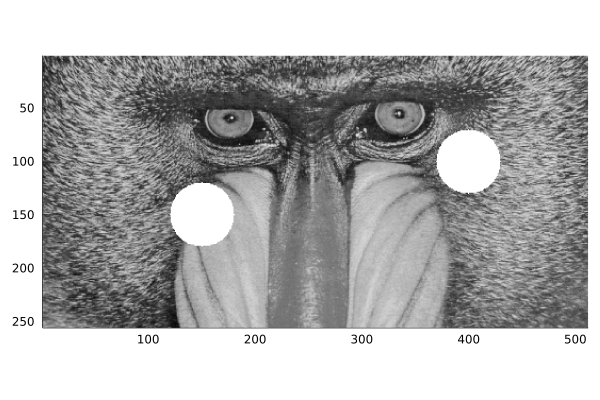

In [78]:
img = testimage("mandrill");
print(size(img))
imgg = Gray.(img);
rows, columns = (256, 512)
N = rows*columns

mat = convert(Array{Float64}, imgg)[1:rows,1:columns]
cent = [(150, 150), (100, 400)]
rad = 30*ones(Int64, 2)
discard2 = punch_holes_2D(cent, rad, rows, columns);
holeyimage1 = copy(mat)
holeyimage1[discard2] .= 1
plot(Gray.(holeyimage1))

## Interpolation with Dirichlet Boundaries

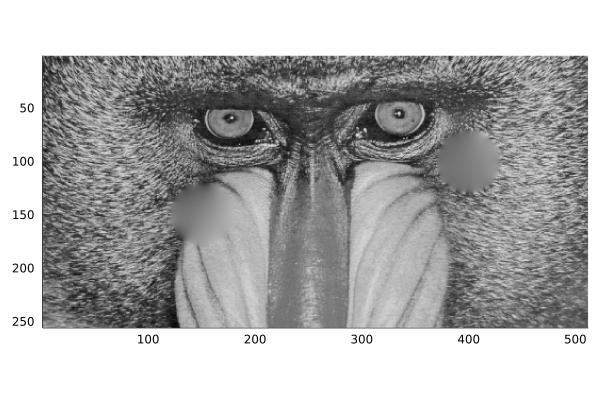

In [80]:
m = 1
epsilon = 0.0
restored_data_laplace = matern_2d_grid(holeyimage1, discard2, m, epsilon, h, h);
plot(Gray.(restored_data_laplace))

## Interpolation with Neumann Boundaries

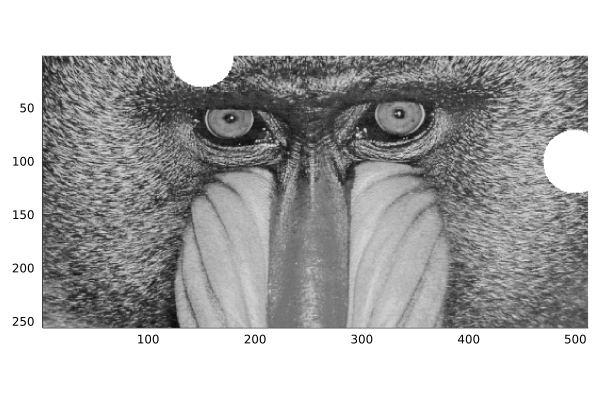

In [81]:
cent = [(0, 150), (100, 500)]
rad = 30*ones(Int64, 2)
discard2 = punch_holes_2D(cent, rad, rows, columns);
holeyimage1 = copy(mat)
holeyimage1[discard2] .= 1
plot(Gray.(holeyimage1))

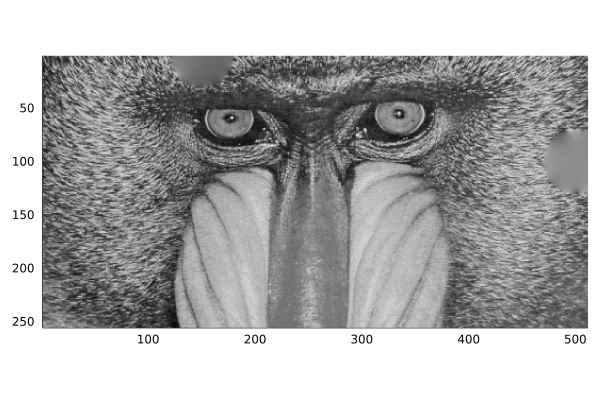

In [82]:
m = 1
epsilon = 0.0
bc = 1 
restored_data_laplace_n = matern_2d_grid(holeyimage1, discard2, m, epsilon, h, h, bc);
plot(Gray.(restored_data_laplace_n))

## Interpolation with "Do Nothing" Boundaries 

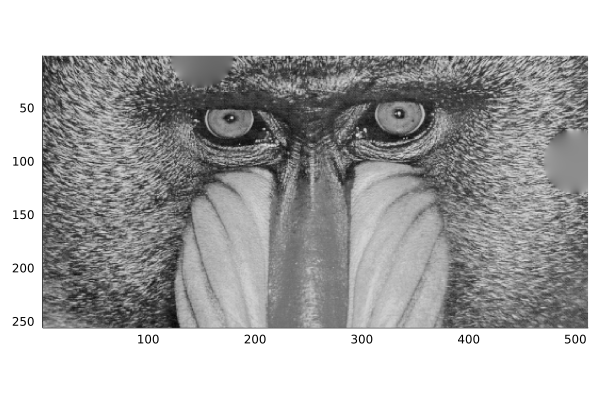

In [83]:
m = 1
epsilon = 0.0
bc = 0 
restored_data_laplace_dn = matern_2d_grid(holeyimage1, discard2, m, epsilon, h, h, bc);
plot(Gray.(restored_data_laplace_dn))

# 3D Example
We demonstrate a 3D-example on a truncated Gaussian surface.

In [174]:
function f(x, y, z)
    lenx = length(x)
    leny = length(y)
    lenz = length(z)
    centerx = div(lenx, 2)
    centery = div(leny, 2)
    centerz = div(lenz, 2)
    f = zeros(lenx, leny, lenz)
    for i = 1:lenx
        for j = 1:leny
            for k = 1:lenz
                f[i,j,k] = exp(-(x[i] - centerx)^2/(2*centerx^2) - (y[j] - centery)^2/(2*centery^2)
                -(z[k] - centerz)^2/(2*centerz^2))
            end
        end
    end
    return f
end

f (generic function with 2 methods)

In [175]:
Nx = 21
Ny = 21
Nz = 21
x = 1:Nx
y = 1:Ny
z = 1:Nz
f_true = f(x,y,z);

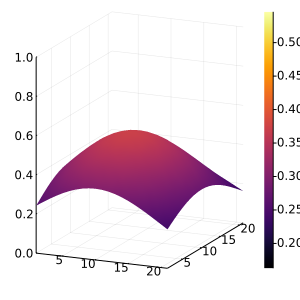

In [176]:
GR.inline()
nsteps = 21
for n = 1:nsteps
    IJulia.clear_output(true)
    surface(x, y, f_true[:,:,n], zlims=(0,1), size = (300, 300))  |> display
end

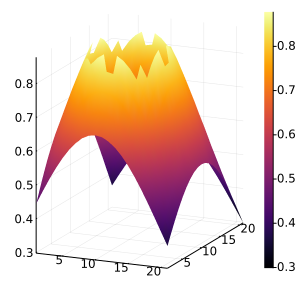

In [177]:
center =[10,10,10]
radius = 5
absolute_indices = punch_3D_cart(center, radius, x, y, z);
f_copy = copy(f_true)
f_copy[absolute_indices] .= NaN 
surface(x,y,f_copy[:,:,10], size = (300, 300))

## Interpolation with Dirichlet Boundaries¶

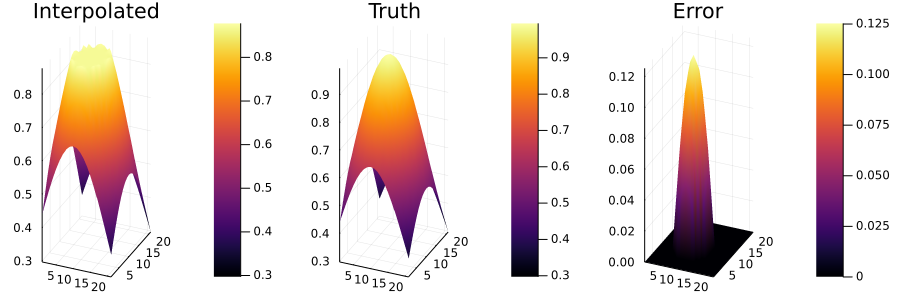

In [198]:
m =1
epsilon = 0.0
h = 1
z_axis = 11
restored_img = matern_3d_grid(f_copy, absolute_indices, m, epsilon, h, h, h)
restored_img = reshape(restored_img, Nx, Ny, Nz)
error_lap = abs.(f_true[:,:,z_axis] - restored_img[:,:,z_axis])
plot(surface(x,y,restored_img[:,:,z_axis],  title="Interpolated"),
surface(x,y,f_true[:,:,z_axis], title="Truth"), 
surface(x,y, error_lap, title="Error"), 
    size = (900, 300), layout=(1,3))

## Interpolation with Neumann Boundaries¶ 

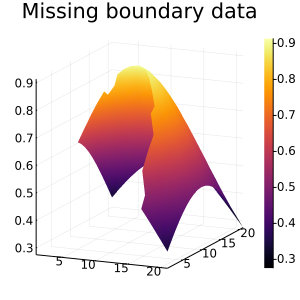

In [199]:
center =[2,6,6]
radius = 10
absolute_indices = punch_3D_cart(center, radius, x, y, z);
f_copy = copy(f_true)
f_copy[absolute_indices] .= NaN 
surface(f_copy[:,:,6], size = (300, 300), title=:"Missing boundary data")

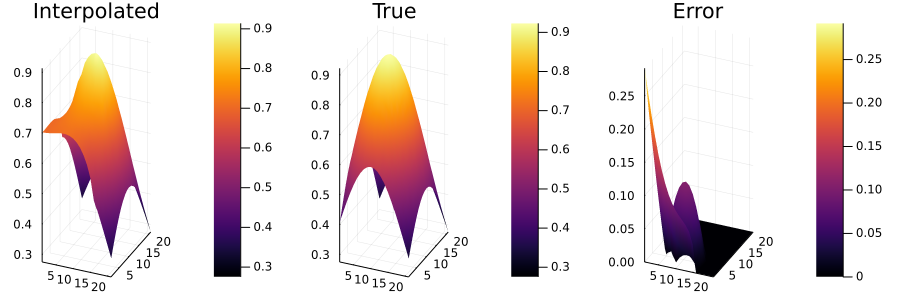

In [200]:
bc = 1 
z_axis = 6
restored_img = matern_3d_grid(f_copy, absolute_indices, m, epsilon, h, h, h, bc)
restored_img = reshape(restored_img, Nx, Ny, Nz)
plot(surface(x,y,restored_img[:,:,z_axis], size = (900, 300), title=:Interpolated),
surface(x,y,f_true[:,:,z_axis], size = (900, 300), title=:True), 
surface(x,y,abs.(f_true[:,:,z_axis] - restored_img[:,:,z_axis]) , size = (900, 300), title=:Error),  
    layout=(1,3))

## Interpolation with "do nothing" boundary conditions

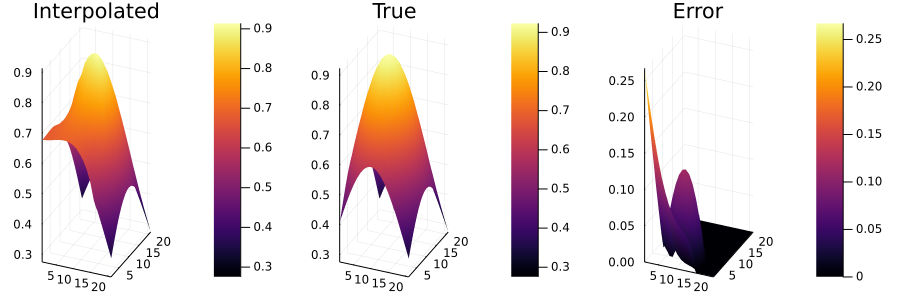

In [202]:
bc = 0
restored_img = matern_3d_grid(f_copy, absolute_indices,m, epsilon, h, h, h, bc)
restored_img = reshape(restored_img, Nx, Ny, Nz)
plot(surface(x,y,restored_img[:,:,z_axis], size = (900, 300), title=:Interpolated),
surface(x,y,f_true[:,:,z_axis], size = (900, 300), title=:True), 
surface(x,y,abs.(f_true[:,:,z_axis] - restored_img[:,:,z_axis]) , size = (900, 300), title="Error"),  
    layout=(1,3))

This example is memory intensive and we recommend using a system with about 16GB
of memory to run this example.

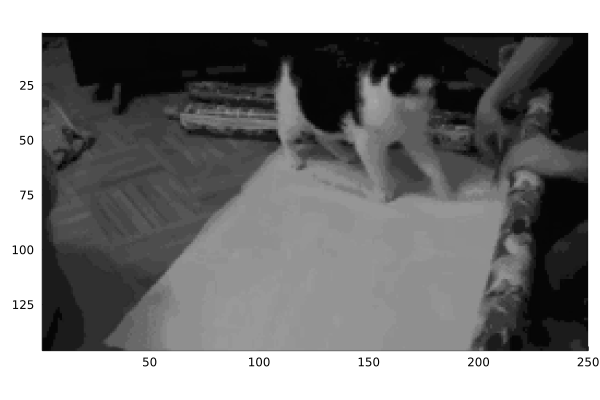

(146, 250, 126)

In [102]:
obj = load("cat_bow.gif")
GR.inline()
nsteps = 14
imgg = Gray.(obj)
for n = 1:nsteps
    IJulia.clear_output(true)
    Plots.heatmap(imgg[:,:,n])  |> display
end
print(size(imgg))

In [103]:
Nx = size(imgg,1)
Ny = size(imgg,2)
Nz = size(imgg, 3)
x = 1:Nx
y = 1:Ny
z = 1:Nz
center =[75,100, 40]
radius = 30
absolute_indices = punch_3D_cart(center, radius, x, y, z);

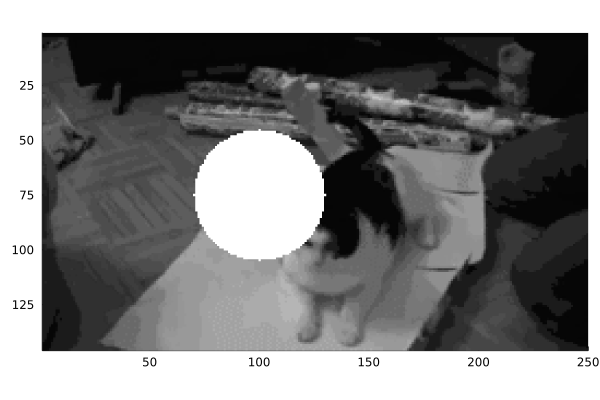

In [104]:
imgg_copy = copy(imgg)
imgg_copy[absolute_indices] .= 1
Plots.heatmap(imgg_copy[:,:,40])

## Interpolation with Dirichlet Boundaries¶

In [105]:
m =1
epsilon = 0.0
h = 1
img_array = convert(Array{Float64}, imgg_copy)
restored_img = matern_3d_grid(img_array, absolute_indices,m, epsilon, h, h, h)
restored_img = reshape(restored_img, Nx, Ny, Nz)

146×250×126 Array{Float64,3}:
[:, :, 1] =
 0.0196078  0.0196078  0.0196078  …  0.0196078  0.0196078  0.0196078
 0.0196078  0.0352941  0.0941176     0.0196078  0.0196078  0.0196078
 0.0235294  0.137255   0.262745      0.0196078  0.0196078  0.0196078
 0.0235294  0.105882   0.176471      0.0196078  0.0196078  0.0196078
 0.0196078  0.0941176  0.105882      0.0196078  0.0196078  0.0196078
 0.0352941  0.0941176  0.105882   …  0.0196078  0.0196078  0.0196078
 0.160784   0.160784   0.188235      0.0196078  0.0196078  0.0196078
 0.219608   0.219608   0.254902      0.0196078  0.0196078  0.0196078
 0.219608   0.254902   0.290196      0.0196078  0.0196078  0.0196078
 0.219608   0.219608   0.262745      0.0196078  0.0196078  0.0196078
 0.176471   0.219608   0.203922   …  0.0196078  0.0196078  0.0196078
 0.105882   0.137255   0.188235      0.0196078  0.0196078  0.0196078
 0.105882   0.105882   0.176471      0.0196078  0.0196078  0.0196078
 ⋮                                ⋱                        
 

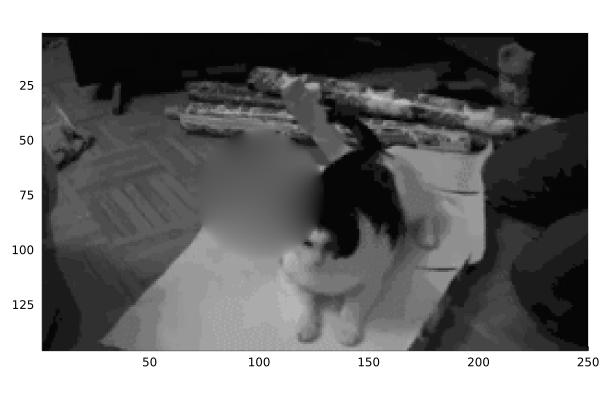

In [106]:
Plots.heatmap(Gray.(restored_img[:,:,40]))

## Interpolation with Neumann Boundaries¶ 

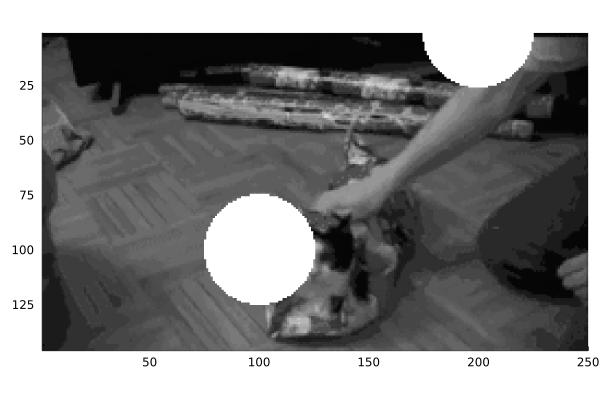

In [107]:
center =[0,200,110]
radius = 30
absolute_indices1 = punch_3D_cart(center, radius, x, y, z);
center =[100,100,110]
absolute_indices2 = punch_3D_cart(center, radius, x,y,z)
imgg_copy = copy(imgg)
absolute_indices = [absolute_indices1; absolute_indices2] #We discard data on the boundary
imgg_copy[absolute_indices] .= 1 
Plots.heatmap(imgg_copy[:,:,126]) 

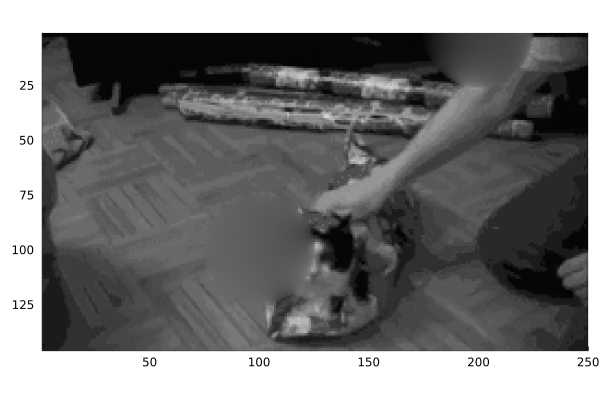

In [108]:
img_array = convert(Array{Float64}, imgg_copy)
bc = 1 
restored_img = matern_3d_grid(img_array, absolute_indices,m, epsilon, h, h, h, bc)
restored_img = reshape(restored_img, Nx, Ny, Nz)
Plots.heatmap(Gray.(restored_img[:,:,126])) 

## Interpolation with "do nothing" boundary conditions

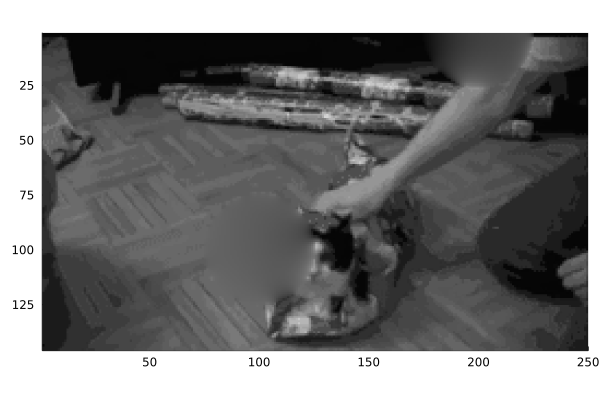

In [109]:
bc = 0 
restored_img = matern_3d_grid(img_array, absolute_indices,m, epsilon, h, h, h, bc)
restored_img = reshape(restored_img, Nx, Ny, Nz)
Plots.heatmap(Gray.(restored_img[:,:,126])) 

# References

[1] Press, William H., et al. Numerical recipes in Fortran 77: volume 1, volume 1 of Fortran numerical recipes: the art of scientific computing. Cambridge university press, 1992.

[2] Strikwerda, John C. Finite difference schemes and partial differential equations. Society for Industrial and Applied Mathematics, 2004.